In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/chartevents_vitals.csv'

# Load the CSV into a DataFrame
vitals = pd.read_csv(file_path)

# Display the first few rows to confirm it loaded correctly
print(vitals.head())

   subject_id   stay_id            charttime  itemid value  valuenum
0    10002428  38875437  2156-04-22 07:00:00  224689     0       0.0
1    10002428  38875437  2156-04-22 09:00:00  224689    26      26.0
2    10002428  38875437  2156-04-22 12:00:00  224689    24      24.0
3    10002428  38875437  2156-04-22 13:00:00  224689    23      23.0
4    10002428  38875437  2156-04-22 15:00:00  224689    22      22.0


In [3]:
vitals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7284714 entries, 0 to 7284713
Data columns (total 6 columns):
 #   Column      Dtype  
---  ------      -----  
 0   subject_id  int64  
 1   stay_id     int64  
 2   charttime   object 
 3   itemid      int64  
 4   value       object 
 5   valuenum    float64
dtypes: float64(1), int64(3), object(2)
memory usage: 333.5+ MB


In [4]:
# Convert charttime to an datetime
vitals['charttime'] = vitals['charttime'].astype('datetime64[ns]')
vitals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7284714 entries, 0 to 7284713
Data columns (total 6 columns):
 #   Column      Dtype         
---  ------      -----         
 0   subject_id  int64         
 1   stay_id     int64         
 2   charttime   datetime64[ns]
 3   itemid      int64         
 4   value       object        
 5   valuenum    float64       
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 333.5+ MB


In [5]:
# Count the number of unique subject_ids / patients in this dataframe
print(f'Number of patients: {vitals["subject_id"].nunique()}')

Number of patients: 5832


In [6]:
# Load the d_items CSV
d_items_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/mimic-iv-3.1/icu/d_items.csv'
d_items = pd.read_csv(d_items_path)

# Merge the label column into the ventilation dataframe using itemid
vitals = vitals.merge(
    d_items[['itemid', 'label']],  # Only keep necessary columns
    on='itemid',
    how='left'  # Keep all rows from ventilation
)

In [7]:
vitals.head()

,subject_id,stay_id,charttime,itemid,value,valuenum,label
0,10002428,38875437,2156-04-22 07:00:00,224689,0,0.0,Respiratory Rate (spontaneous)
1,10002428,38875437,2156-04-22 09:00:00,224689,26,26.0,Respiratory Rate (spontaneous)
2,10002428,38875437,2156-04-22 12:00:00,224689,24,24.0,Respiratory Rate (spontaneous)
3,10002428,38875437,2156-04-22 13:00:00,224689,23,23.0,Respiratory Rate (spontaneous)
4,10002428,38875437,2156-04-22 15:00:00,224689,22,22.0,Respiratory Rate (spontaneous)


In [8]:
vitals.shape

(7284714, 7)

In [9]:
# Group by itemid and count nulls in both 'value' and 'valuenum' columns
null_counts = vitals.groupby('itemid').agg(
    null_value=('value', lambda x: x.isnull().sum()),
    null_valuenum=('valuenum', lambda x: x.isnull().sum())
).reset_index()

In [10]:
null_counts

,itemid,null_value,null_valuenum
0,220045,0,0
1,220050,0,0
2,220051,0,0
3,220052,0,0
4,220179,0,0
5,220180,0,0
6,220181,0,0
7,220277,0,0
8,223761,0,0
9,223762,0,0


In [11]:
# Load the d_items CSV
d_items_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/mimic-iv-3.1/icu/d_items.csv'
d_items = pd.read_csv(d_items_path)

# Merge the label column with null_counts using itemid
null_counts = null_counts.merge(
    d_items[['itemid', 'label']],  
    on='itemid',
    how='left' 
)

null_counts

,itemid,null_value,null_valuenum,label
0,220045,0,0,Heart Rate
1,220050,0,0,Arterial Blood Pressure systolic
2,220051,0,0,Arterial Blood Pressure diastolic
3,220052,0,0,Arterial Blood Pressure mean
4,220179,0,0,Non Invasive Blood Pressure systolic
5,220180,0,0,Non Invasive Blood Pressure diastolic
6,220181,0,0,Non Invasive Blood Pressure mean
7,220277,0,0,O2 saturation pulseoxymetry
8,223761,0,0,Temperature Fahrenheit
9,223762,0,0,Temperature Celsius


In [12]:
# Average, minimum and maximum time of each individual in dataframe

# Group by subject_id and calculate duration per subject
duration_per_subject = vitals.groupby('subject_id')['charttime'].agg(['min', 'max'])
duration_per_subject['duration_hours'] = (
    (duration_per_subject['max'] - duration_per_subject['min']).dt.total_seconds() / 3600
)

# Summary statistics
average_duration = duration_per_subject['duration_hours'].mean()
min_duration = duration_per_subject['duration_hours'].min()
max_duration = duration_per_subject['duration_hours'].max()

print(f"🟢 Average time span per subject: {average_duration:.2f} hours")
print(f"🔵 Shortest time span: {min_duration:.2f} hours")
print(f"🔴 Longest time span: {max_duration:.2f} hours")

🟢 Average time span per subject: 261.32 hours
🔵 Shortest time span: 20.00 hours
🔴 Longest time span: 64936.85 hours


In [13]:
# Group by itemid
grouped = vitals.groupby('itemid')

# Define the frequency function
def avg_obs_per_20_hours(group):
    n_obs = len(group)
    time_span_hours = (group['charttime'].max() - group['charttime'].min()).total_seconds() / 3600
    return (n_obs / time_span_hours * 20) if time_span_hours > 0 else float('nan')

# Apply the function to the cleaned dataframe
avg_freq_df = grouped.apply(avg_obs_per_20_hours).reset_index(name='avg_obs_per_20_hours')

/var/folders/ks/xzsx5z1n0zv653847sbsxy7r0000gp/T/ipykernel_33692/2943213143.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  avg_freq_df = grouped.apply(avg_obs_per_20_hours).reset_index(name='avg_obs_per_20_hours')


In [14]:
avg_freq_df

,itemid,avg_obs_per_20_hours
0,220045,30.598157
1,220050,16.558836
2,220051,16.555715
3,220052,16.611341
4,220179,14.358504
5,220180,14.354168
6,220181,14.364859
7,220277,30.223309
8,223761,7.261755
9,223762,1.326592


In [15]:
# Load the d_items CSV
d_items_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/mimic-iv-3.1/icu/d_items.csv'
d_items = pd.read_csv(d_items_path)

# Merge the label column with null_counts using itemid
avg_freq_df = avg_freq_df.merge(
    d_items[['itemid', 'label']],  
    on='itemid',
    how='left' 
)

avg_freq_df

,itemid,avg_obs_per_20_hours,label
0,220045,30.598157,Heart Rate
1,220050,16.558836,Arterial Blood Pressure systolic
2,220051,16.555715,Arterial Blood Pressure diastolic
3,220052,16.611341,Arterial Blood Pressure mean
4,220179,14.358504,Non Invasive Blood Pressure systolic
5,220180,14.354168,Non Invasive Blood Pressure diastolic
6,220181,14.364859,Non Invasive Blood Pressure mean
7,220277,30.223309,O2 saturation pulseoxymetry
8,223761,7.261755,Temperature Fahrenheit
9,223762,1.326592,Temperature Celsius


In [16]:
# Dropping features that are measured < 4 per 20-hour period

# drop specific itemids
itemids_to_drop = [223762, 228232]
vitals2 = vitals[~vitals['itemid'].isin(itemids_to_drop)].copy()

In [17]:
vitals2.shape

(7227016, 7)

In [18]:
# Check for outliers in the dataframe

summary_stats = vitals2.groupby('itemid')['valuenum'].agg(
    min_value='min',
    max_value='max',
    median_value='median'
).reset_index()

# Load the d_items CSV
d_items_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/mimic-iv-3.1/icu/d_items.csv'
d_items = pd.read_csv(d_items_path)

# Merge the label column with null_counts using itemid
summary_stats = summary_stats.merge(
    d_items[['itemid', 'label']],  
    on='itemid',
    how='left' 
)

print(summary_stats)

    itemid  min_value  max_value  median_value  \
0   220045      -88.0     6632.0          87.0   
1   220050        0.0    87118.0         117.0   
2   220051      -20.0   114100.0          57.0   
3   220052      -40.0   117113.0          77.0   
4   220179      -69.0    15092.0         118.0   
5   220180       -2.0    96105.0          62.0   
6   220181   -22767.0  2222220.0          75.0   
7   220277     -678.0  6363330.0          98.0   
8   223761      -18.0      997.5          98.6   
9   224689        0.0     2843.0          11.0   
10  228640        0.0       96.0          36.0   

                                    label  
0                              Heart Rate  
1        Arterial Blood Pressure systolic  
2       Arterial Blood Pressure diastolic  
3            Arterial Blood Pressure mean  
4    Non Invasive Blood Pressure systolic  
5   Non Invasive Blood Pressure diastolic  
6        Non Invasive Blood Pressure mean  
7             O2 saturation pulseoxymetry  
8  

In [19]:
# Define valid ranges for specific itemids
valid_ranges = {
    220045: (0, 210),
    220050: (0, 250),
    220051: (0, 200),
    220052: (0, 200),
    220179: (0, 250),
    220180: (0, 200),
    220181: (0, 200),
    220277: (0, 100),
    223761: (0, 110),
    224689: (0, 50),
    228640: (0, 100)
}

# Remove all negative valuenums (for all itemids)
vitals3 = vitals2.copy()
vitals3 = vitals3[vitals3['valuenum'] >= 0]

to_filter = vitals3[vitals3['itemid'].isin(valid_ranges.keys())].copy()

# Apply physiological range filtering to the filtered subset
def in_valid_range(row):
    low, high = valid_ranges[row['itemid']]
    return low <= row['valuenum'] <= high

vitals3 = to_filter[to_filter.apply(in_valid_range, axis=1)]

In [20]:
vitals3.shape

(7224013, 7)

In [21]:
vitals3.head()

,subject_id,stay_id,charttime,itemid,value,valuenum,label
0,10002428,38875437,2156-04-22 07:00:00,224689,0,0.0,Respiratory Rate (spontaneous)
1,10002428,38875437,2156-04-22 09:00:00,224689,26,26.0,Respiratory Rate (spontaneous)
2,10002428,38875437,2156-04-22 12:00:00,224689,24,24.0,Respiratory Rate (spontaneous)
3,10002428,38875437,2156-04-22 13:00:00,224689,23,23.0,Respiratory Rate (spontaneous)
4,10002428,38875437,2156-04-22 15:00:00,224689,22,22.0,Respiratory Rate (spontaneous)


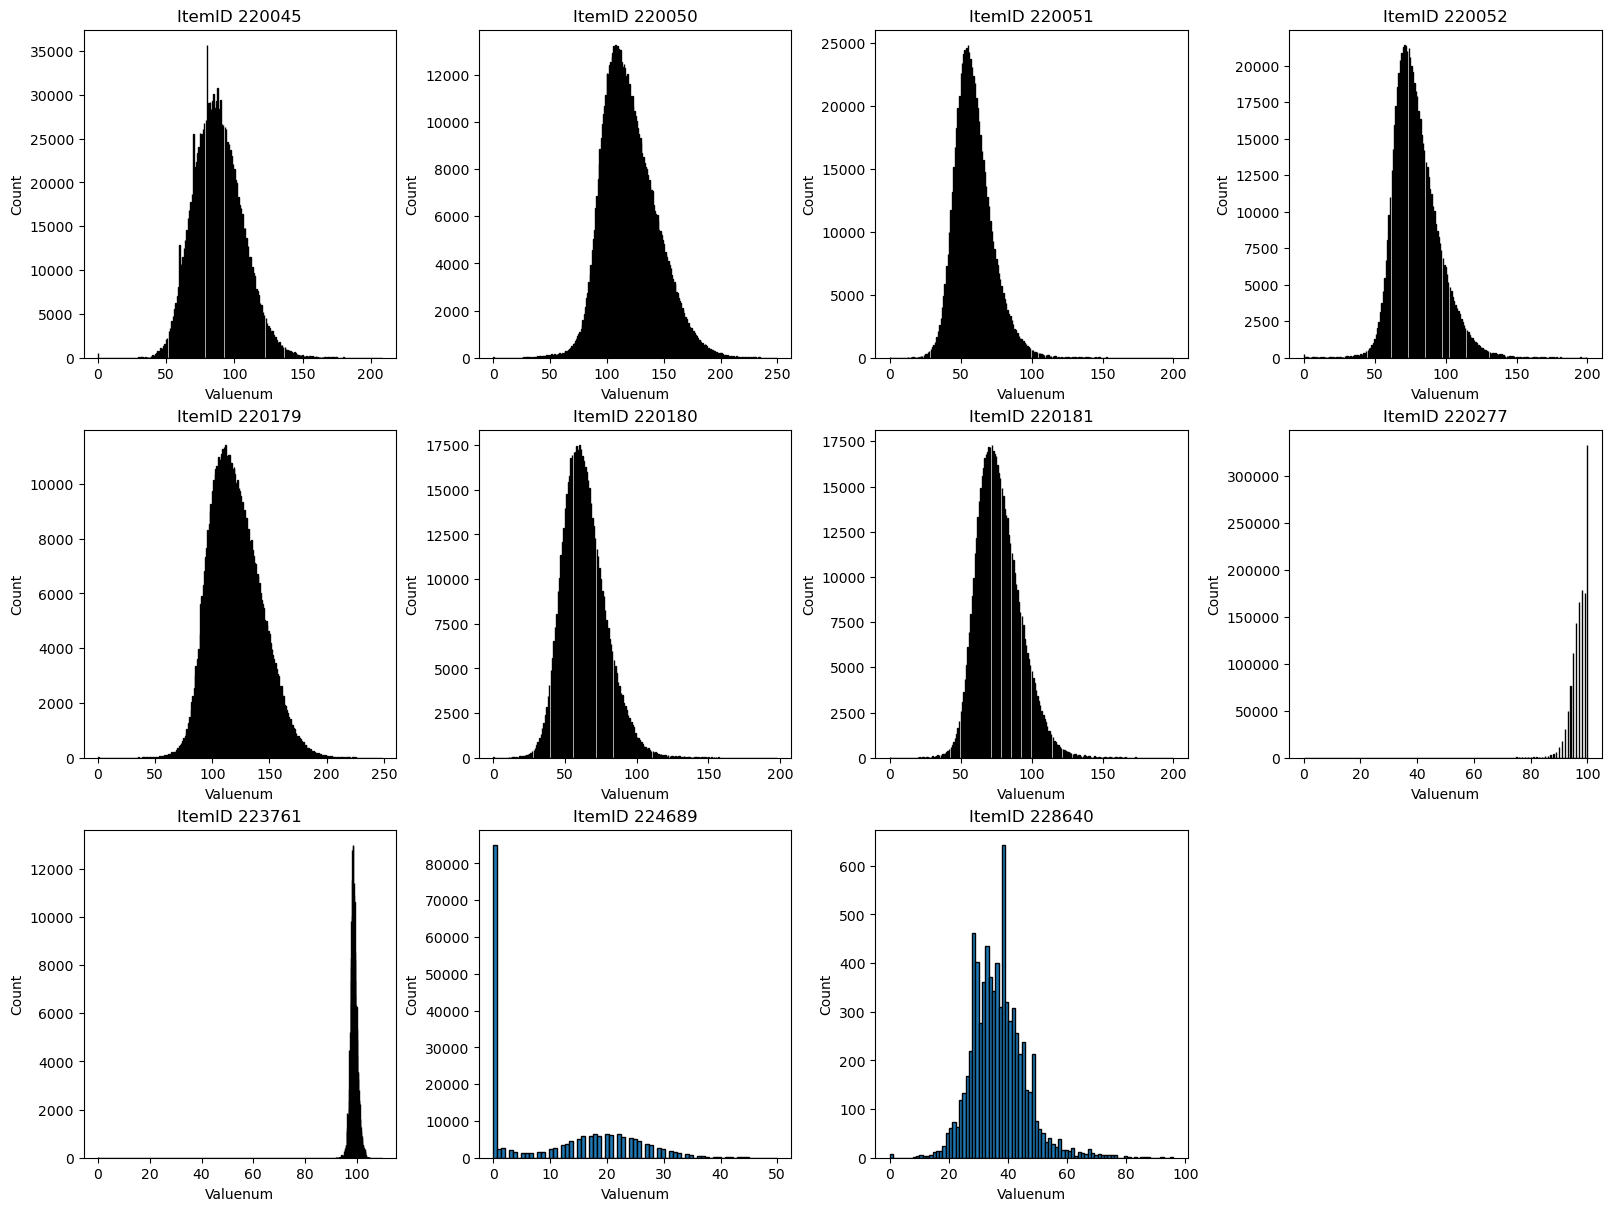

In [22]:
# Get unique itemids from vitals3
itemids = vitals3['itemid'].unique()

# Filter NaNs in valuenum
filtered = vitals3[vitals3['valuenum'].notna() & vitals3['itemid'].isin(itemids)]

# Group by itemid
grouped = filtered.groupby('itemid')['valuenum']

# Keep only non-empty groups
data_dict = {itemid: group for itemid, group in grouped if not group.empty}

# Plot configuration
n = len(data_dict)
cols = 4
rows = (n + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows), constrained_layout=True)
axes = axes.flatten()

# Plot histograms
for ax, (itemid, data) in zip(axes, data_dict.items()):
    ax.hist(data, bins='auto', edgecolor='black')
    ax.set_title(f'ItemID {itemid}')
    ax.set_xlabel('Valuenum')
    ax.set_ylabel('Count')

# Hide any unused subplots
for ax in axes[n:]:
    ax.set_visible(False)

plt.show()

In [23]:
# Check for outliers in the dataframe

summary_stats = vitals3.groupby('itemid')['valuenum'].agg(
    min_value='min',
    max_value='max',
    median_value='median'
).reset_index()

# Load the d_items CSV
d_items_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/mimic-iv-3.1/icu/d_items.csv'
d_items = pd.read_csv(d_items_path)

# Merge the label column with null_counts using itemid
summary_stats = summary_stats.merge(
    d_items[['itemid', 'label']],  
    on='itemid',
    how='left' 
)

print(summary_stats)

    itemid  min_value  max_value  median_value  \
0   220045        0.0      208.0          87.0   
1   220050        0.0      250.0         117.0   
2   220051        0.0      200.0          57.0   
3   220052        0.0      200.0          77.0   
4   220179        0.0      248.0         118.0   
5   220180        0.0      198.0          62.0   
6   220181        0.0      200.0          75.0   
7   220277        0.0      100.0          98.0   
8   223761        0.0      109.5          98.6   
9   224689        0.0       50.0          11.0   
10  228640        0.0       96.0          36.0   

                                    label  
0                              Heart Rate  
1        Arterial Blood Pressure systolic  
2       Arterial Blood Pressure diastolic  
3            Arterial Blood Pressure mean  
4    Non Invasive Blood Pressure systolic  
5   Non Invasive Blood Pressure diastolic  
6        Non Invasive Blood Pressure mean  
7             O2 saturation pulseoxymetry  
8  

In [24]:
vitals4 = vitals3.copy()

In [25]:
file_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/postwean.csv'

# Load the CSV into a DataFrame
outcomes = pd.read_csv(file_path)

outcomes = outcomes[['subject_id', 'stay_id', 'ventilation_time', 'ext_success']]
outcomes = outcomes.drop_duplicates()
vitals4 = pd.merge(
    vitals4,
    outcomes[['subject_id', 'stay_id', 'ext_success']],
    on=['subject_id', 'stay_id'],
    how='inner'  # 
)

In [26]:
vitals4.head()

,subject_id,stay_id,charttime,itemid,value,valuenum,label,ext_success
0,10002428,38875437,2156-04-22 07:00:00,224689,0,0.0,Respiratory Rate (spontaneous),1
1,10002428,38875437,2156-04-22 09:00:00,224689,26,26.0,Respiratory Rate (spontaneous),1
2,10002428,38875437,2156-04-22 12:00:00,224689,24,24.0,Respiratory Rate (spontaneous),1
3,10002428,38875437,2156-04-22 13:00:00,224689,23,23.0,Respiratory Rate (spontaneous),1
4,10002428,38875437,2156-04-22 15:00:00,224689,22,22.0,Respiratory Rate (spontaneous),1


In [27]:
# Group by subject_id, stay_id, and itemid, count number of samples
group_counts = (
    vitals4
    .groupby(['subject_id', 'stay_id', 'itemid'])
    .size()
    .reset_index(name='sample_count')
)

# Compute average sample count per itemid
avg_samples = (
    group_counts
    .groupby('itemid')['sample_count']
    .mean()
    .reset_index(name='avg_samples_per_subject_stay')
)

# If 'label' exists and is associated uniquely with itemid, merge it in
if 'label' in vitals4.columns:
    itemid_label_map = vitals4[['itemid', 'label']].drop_duplicates()
    avg_samples = avg_samples.merge(itemid_label_map, on='itemid', how='left')

# Reorder columns if needed
avg_samples = avg_samples[['itemid', 'label', 'avg_samples_per_subject_stay']] if 'label' in avg_samples.columns else avg_samples

In [28]:
avg_samples

,itemid,label,avg_samples_per_subject_stay
0,220045,Heart Rate,269.845343
1,220050,Arterial Blood Pressure systolic,195.808713
2,220051,Arterial Blood Pressure diastolic,195.673622
3,220052,Arterial Blood Pressure mean,194.631175
4,220179,Non Invasive Blood Pressure systolic,127.200994
5,220180,Non Invasive Blood Pressure diastolic,127.147190
6,220181,Non Invasive Blood Pressure mean,127.209697
7,220277,O2 saturation pulseoxymetry,266.668083
8,223761,Temperature Fahrenheit,64.280355
9,224689,Respiratory Rate (spontaneous),42.128127


In [29]:
vitals5 = vitals4.copy()

In [30]:
# As feature windows need to be the same length, I will isolate the last 24h of each subject_id and stay_id combination

from datetime import timedelta

file_path = '/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/postwean.csv'

# Load the CSV into a DataFrame
outcomes = pd.read_csv(file_path)

# Ensure datetime formats
for col in ['ventilation_endtime', 'extubation_time', 'deathtime']:
    outcomes[col] = pd.to_datetime(outcomes[col])
vitals5['charttime'] = pd.to_datetime(vitals5['charttime'])

# Create an empty list to hold the filtered results
vitals6_parts = []

# Optional: tqdm for progress tracking (pip install tqdm if needed)
from tqdm import tqdm

# Group outcomes by subject_id and stay_id
grouped_outcomes = outcomes.groupby(['subject_id', 'stay_id'])

# Loop through each unique patient-stay combination
for (subject_id, stay_id), group in tqdm(grouped_outcomes, total=len(grouped_outcomes)):

    # Get the latest of the 3 possible times
    reference_time = pd.to_datetime(
        group[['ventilation_endtime', 'extubation_time', 'deathtime']].max(axis=1).iloc[0]
    )
    
    if pd.isnull(reference_time):
        continue  # skip if no valid time

    # Filter ventilation5 for the same subject/stay in the 24h window
    mask = (
        (vitals5['subject_id'] == subject_id) &
        (vitals5['stay_id'] == stay_id) &
        (vitals5['charttime'] >= reference_time - timedelta(hours=24)) &
        (vitals5['charttime'] <= reference_time)
    )
    filtered = vitals5[mask]

    if not filtered.empty:
        vitals6_parts.append(filtered)

# Combine all filtered chunks
vitals6 = pd.concat(vitals6_parts, ignore_index=True)

100%|███████████████████████████████████████| 5884/5884 [04:02<00:00, 24.29it/s]


In [31]:
vitals6.head()

,subject_id,stay_id,charttime,itemid,value,valuenum,label,ext_success
0,10002428,38875437,2156-04-22 07:00:00,224689,0,0.0,Respiratory Rate (spontaneous),1
1,10002428,38875437,2156-04-22 09:00:00,224689,26,26.0,Respiratory Rate (spontaneous),1
2,10002428,38875437,2156-04-22 12:00:00,224689,24,24.0,Respiratory Rate (spontaneous),1
3,10002428,38875437,2156-04-22 13:00:00,224689,23,23.0,Respiratory Rate (spontaneous),1
4,10002428,38875437,2156-04-22 15:00:00,224689,22,22.0,Respiratory Rate (spontaneous),1


In [32]:
import os

vitals6.to_csv("/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/vitals_cleaned_combi.csv", index=False)

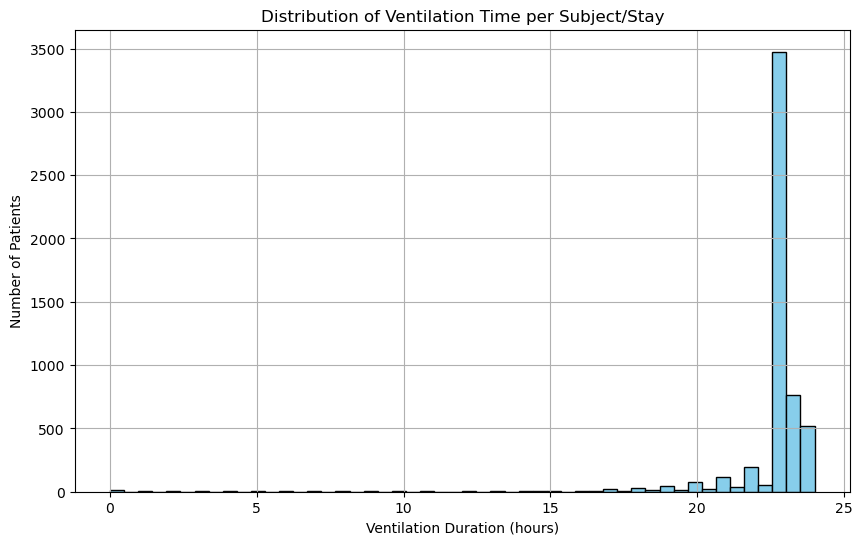

In [172]:
# Group by subject_id and stay_id and compute duration
duration_df = (
    vitals6
    .groupby(['subject_id', 'stay_id'])['charttime']
    .agg(['min', 'max'])
    .reset_index()
)

# Calculate duration in hours
duration_df['duration_hours'] = (duration_df['max'] - duration_df['min']).dt.total_seconds() / 3600

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(duration_df['duration_hours'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Ventilation Duration (hours)')
plt.ylabel('Number of Patients')
plt.title('Distribution of Ventilation Time per Subject/Stay')
plt.grid(True)
plt.show()

In [173]:
# Remove patients with < 20h data

duration_df = (
    vitals6
    .groupby(['subject_id', 'stay_id'])['charttime']
    .agg(start_time='min', end_time='max')
    .reset_index()
)

# Calculate duration in hours
duration_df['duration_hours'] = (
    (duration_df['end_time'] - duration_df['start_time']).dt.total_seconds() / 3600
)

# Filter to keep only combinations with at least 20 hours
valid_stays = duration_df[duration_df['duration_hours'] >= 20][['subject_id', 'stay_id']]

# Filter ventilation6 using only valid subject_id & stay_id
vitals6_filtered = vitals6.merge(valid_stays, on=['subject_id', 'stay_id'], how='inner')

# Reset index
vitals6 = vitals6_filtered.reset_index(drop=True)
vitals6.shape

(826290, 8)

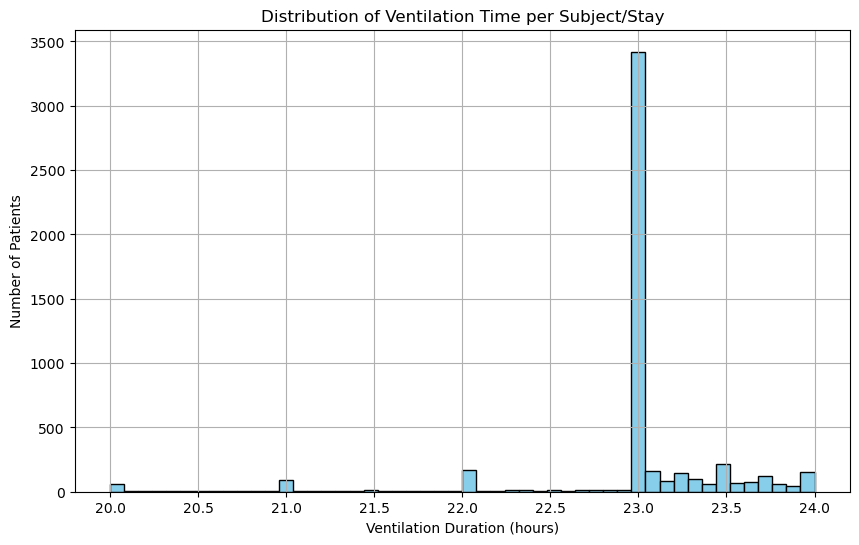

In [174]:
# Group by subject_id and stay_id and compute duration
duration_df = (
    vitals6
    .groupby(['subject_id', 'stay_id'])['charttime']
    .agg(['min', 'max'])
    .reset_index()
)

# Calculate duration in hours
duration_df['duration_hours'] = (duration_df['max'] - duration_df['min']).dt.total_seconds() / 3600

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(duration_df['duration_hours'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Ventilation Duration (hours)')
plt.ylabel('Number of Patients')
plt.title('Distribution of Ventilation Time per Subject/Stay')
plt.grid(True)
plt.show()

In [175]:
# Group by subject_id, stay_id, and itemid, count number of samples
group_counts = (
    vitals6
    .groupby(['subject_id', 'stay_id', 'itemid'])
    .size()
    .reset_index(name='sample_count')
)

# Compute average sample count per itemid
avg_samples = (
    group_counts
    .groupby('itemid')['sample_count']
    .mean()
    .reset_index(name='avg_samples_per_subject_stay')
)

# If 'label' exists and is associated uniquely with itemid, merge it in
if 'label' in vitals6.columns:
    itemid_label_map = vitals6[['itemid', 'label']].drop_duplicates()
    avg_samples = avg_samples.merge(itemid_label_map, on='itemid', how='left')

# Reorder columns if needed
avg_samples = avg_samples[['itemid', 'label', 'avg_samples_per_subject_stay']] if 'label' in avg_samples.columns else avg_samples

In [176]:
avg_samples

,itemid,label,avg_samples_per_subject_stay
0,220045,Heart Rate,28.949724
1,220050,Arterial Blood Pressure systolic,27.672858
2,220051,Arterial Blood Pressure diastolic,27.653293
3,220052,Arterial Blood Pressure mean,27.652732
4,220179,Non Invasive Blood Pressure systolic,18.560049
5,220180,Non Invasive Blood Pressure diastolic,18.553770
6,220181,Non Invasive Blood Pressure mean,18.577743
7,220277,O2 saturation pulseoxymetry,28.364295
8,223761,Temperature Fahrenheit,7.039883
9,224689,Respiratory Rate (spontaneous),6.680224


In [177]:
vitals7 = vitals6.copy()

# Remove itemid 224689 as contained within the ventilation features
vitals7 = vitals7[vitals7['itemid'] != 224689]

In [178]:
vitals7.shape

(792949, 8)

In [179]:
# Group by subject_id, stay_id, and itemid, count number of samples
group_counts = (
    vitals7
    .groupby(['subject_id', 'stay_id', 'itemid'])
    .size()
    .reset_index(name='sample_count')
)

# Compute average sample count per itemid
avg_samples = (
    group_counts
    .groupby('itemid')['sample_count']
    .mean()
    .reset_index(name='avg_samples_per_subject_stay')
)

# If 'label' exists and is associated uniquely with itemid, merge it in
if 'label' in vitals7.columns:
    itemid_label_map = vitals7[['itemid', 'label']].drop_duplicates()
    avg_samples = avg_samples.merge(itemid_label_map, on='itemid', how='left')

# Reorder columns if needed
avg_samples = avg_samples[['itemid', 'label', 'avg_samples_per_subject_stay']] if 'label' in avg_samples.columns else avg_samples

avg_samples

,itemid,label,avg_samples_per_subject_stay
0,220045,Heart Rate,28.949724
1,220050,Arterial Blood Pressure systolic,27.672858
2,220051,Arterial Blood Pressure diastolic,27.653293
3,220052,Arterial Blood Pressure mean,27.652732
4,220179,Non Invasive Blood Pressure systolic,18.560049
5,220180,Non Invasive Blood Pressure diastolic,18.553770
6,220181,Non Invasive Blood Pressure mean,18.577743
7,220277,O2 saturation pulseoxymetry,28.364295
8,223761,Temperature Fahrenheit,7.039883
9,228640,EtCO2,6.676471


In [180]:
# On the basis of the samples here, aim for a sampling frequency of at least once every 4 hours, which is 7 measurements in 24h

from sklearn.model_selection import train_test_split

target_frequency = 7

In [181]:
def calculate_synthetic_data_proportion(df, patient_id_col, feature_col, target_frequency=13):
    synthetic_data_proportion = {}
    for patient_id in df[patient_id_col].unique():
        patient_data = df[df[patient_id_col] == patient_id]
        total_entries = len(patient_data)
        synthetic_entries = 0
        for feature in df[feature_col].unique():
            feature_data = patient_data[patient_data[feature_col] == feature]
            observed_count = len(feature_data)
            if observed_count < target_frequency:
                synthetic_entries += (target_frequency - observed_count)
        synthetic_data_proportion[patient_id] = synthetic_entries / total_entries
    return synthetic_data_proportion

In [182]:
# Calculate the synthetic data proportion that will be required for each feature
synthetic_data_proportion = calculate_synthetic_data_proportion(vitals7, 'subject_id', 'itemid', target_frequency)
synthetic_data_proportion_df = pd.DataFrame(list(synthetic_data_proportion.items()), columns=['subject_id', 'synthetic_data_proportion'])
synthetic_data_proportion_df

,subject_id,synthetic_data_proportion
0,10002428,0.207407
1,10004235,1.122449
2,10004401,0.250000
3,10004733,0.191781
4,10005817,0.250000
...,...,...
5219,19990821,0.824561
5220,19991446,0.114286
5221,19997293,0.133721
5222,19997367,0.140000


In [183]:
def calculate_patient_synthetic_data_proportion(patient_data, target_frequency=13):
    patient_synthetic_data_proportion = {}
    for patient_id, group in patient_data.groupby('subject_id'):
        observed_count = group['label'].count()
        total_expected = len(group) * target_frequency
        synthetic_count = total_expected - observed_count
        synthetic_proportion = synthetic_count / total_expected
        patient_synthetic_data_proportion[patient_id] = synthetic_proportion
    return patient_synthetic_data_proportion  

In [184]:
def create_synthetic_data_proportion_df(patient_data):
    synthetic_data_proportion = calculate_patient_synthetic_data_proportion(patient_data)
    synthetic_df = pd.DataFrame(list(synthetic_data_proportion.items()), columns=['subject_id', 'synthetic_proportion'])
    return synthetic_df

In [185]:
def stratified_split(patient_data, test_size=0.2, random_state=42):
    synthetic_df = create_synthetic_data_proportion_df(patient_data)
    train_ids, test_ids = train_test_split(
        synthetic_df['subject_id'],
        test_size=test_size,
        random_state=random_state,
        stratify=synthetic_df['synthetic_proportion']
    )
    train_data = patient_data[patient_data['subject_id'].isin(train_ids)]
    test_data = patient_data[patient_data['subject_id'].isin(test_ids)]
    return train_data, test_data

In [186]:
# Split into train and test data
train_data, test_data = stratified_split(vitals7, test_size=0.2, random_state=42)

print(f"Total number of patients in train set: {len(train_data['subject_id'].unique())}")
print(f"Total number of patients in test set: {len(test_data['subject_id'].unique())}")

Total number of patients in train set: 4179
Total number of patients in test set: 1045


In [187]:
def compare_synthetic_data_proportions(train_df, test_df, patient_id_col, feature_col, target_frequency=13):
    train_synthetic_data_proportion = calculate_synthetic_data_proportion(train_df, patient_id_col, feature_col, target_frequency)
    test_synthetic_data_proportion = calculate_synthetic_data_proportion(test_df, patient_id_col, feature_col, target_frequency)

    train_avg_synthetic_data_proportion = sum(train_synthetic_data_proportion.values()) / len(train_synthetic_data_proportion)
    test_avg_synthetic_data_proportion = sum(test_synthetic_data_proportion.values()) / len(test_synthetic_data_proportion)

    print(f"Train Average Synthetic Data Proportion: {train_avg_synthetic_data_proportion:.4f}")
    print(f"Test Average Synthetic Data Proportion: {test_avg_synthetic_data_proportion:.4f}")

def compare_class_distributions(train_df, test_df, target_col):
    train_class_distribution = train_df[target_col].value_counts(normalize=True)
    test_class_distribution = test_df[target_col].value_counts(normalize=True)

    print("Train Class Distribution:")
    print(train_class_distribution)
    print("\nTest Class Distribution:")
    print(test_class_distribution)

def compare_feature_distributions(train_df, test_df, feature_cols):
    train_feature_stats = train_df[feature_cols].describe().transpose()
    test_feature_stats = test_df[feature_cols].describe().transpose()

    comparison_df = train_feature_stats[['mean', 'std']].merge(
        test_feature_stats[['mean', 'std']],
        left_index=True,
        right_index=True,
        suffixes=('_train', '_test')
    )

    print("\nFeature Statistics Comparison:")
    print(comparison_df)

In [188]:
# Synthetic data requirement between test and train datasets

compare_synthetic_data_proportions(train_data, test_data, 'subject_id', 'label', target_frequency)

Train Average Synthetic Data Proportion: 0.2080
Test Average Synthetic Data Proportion: 0.2066


In [189]:
def compare_class_distributions(train_df, test_df, target_col):
    train_class_distribution = train_df[target_col].value_counts(normalize=True)
    test_class_distribution = test_df[target_col].value_counts(normalize=True)

    print("Train Class Distribution:")
    print(train_class_distribution)
    print("\nTest Class Distribution:")
    print(test_class_distribution)

In [190]:
# Outcome proportions between test and train datasets

compare_class_distributions(train_data, test_data, 'ext_success')

Train Class Distribution:
ext_success
1    0.762816
0    0.237184
Name: proportion, dtype: float64

Test Class Distribution:
ext_success
1    0.747525
0    0.252475
Name: proportion, dtype: float64


In [191]:
def compare_feature_stats(train_df, test_df, feature_labels):
    results = []

    for label in feature_labels:
        train_vals = train_df[train_df['label'] == label]['valuenum'].dropna()
        test_vals = test_df[test_df['label'] == label]['valuenum'].dropna()

        if len(train_vals) == 0 or len(test_vals) == 0:
            continue  # skip if no data in one of the splits

        results.append({
            'feature': label,
            'mean_train': train_vals.mean(),
            'std_train': train_vals.std(),
            'mean_test': test_vals.mean(),
            'std_test': test_vals.std()
        })

    comparison_df = pd.DataFrame(results)
    print("\nFeature Statistics Comparison:")
    print(comparison_df)

    return comparison_df

In [192]:
train_data.head()

,subject_id,stay_id,charttime,itemid,value,valuenum,label,ext_success
6,10002428,38875437,2156-04-21 19:00:00,220045,120,120.0,Heart Rate,1
7,10002428,38875437,2156-04-21 19:00:00,220050,104,104.0,Arterial Blood Pressure systolic,1
8,10002428,38875437,2156-04-21 19:00:00,220051,54,54.0,Arterial Blood Pressure diastolic,1
9,10002428,38875437,2156-04-21 19:00:00,220052,71,71.0,Arterial Blood Pressure mean,1
10,10002428,38875437,2156-04-21 19:12:00,220277,100,100.0,O2 saturation pulseoxymetry,1


In [193]:
# Normalise each value using MinMaxScalar

from sklearn.preprocessing import MinMaxScaler

# Create an empty list to hold the normalized data
normalized_frames = []

# Loop through each itemid and normalize valuenum within its group
for itemid, group in train_data.groupby('itemid'):
    scaler = MinMaxScaler()
    group = group.copy()  # avoid SettingWithCopyWarning
    group['valuenum_normalized'] = scaler.fit_transform(group[['valuenum']])
    normalized_frames.append(group)

# Concatenate all normalized groups back together
train_data = pd.concat(normalized_frames, ignore_index=True)

In [194]:
train_data.head()

,subject_id,stay_id,charttime,itemid,value,valuenum,label,ext_success,valuenum_normalized
0,10002428,38875437,2156-04-21 19:00:00,220045,120,120.0,Heart Rate,1,0.576923
1,10002428,38875437,2156-04-21 20:00:00,220045,108,108.0,Heart Rate,1,0.519231
2,10002428,38875437,2156-04-21 21:00:00,220045,108,108.0,Heart Rate,1,0.519231
3,10002428,38875437,2156-04-21 22:00:00,220045,109,109.0,Heart Rate,1,0.524038
4,10002428,38875437,2156-04-21 23:00:00,220045,105,105.0,Heart Rate,1,0.504808


In [195]:
train_data = train_data[['subject_id', 'stay_id', 'charttime', 'itemid', 'label', 'valuenum_normalized', 'ext_success']]

train_data.head()

,subject_id,stay_id,charttime,itemid,label,valuenum_normalized,ext_success
0,10002428,38875437,2156-04-21 19:00:00,220045,Heart Rate,0.576923,1
1,10002428,38875437,2156-04-21 20:00:00,220045,Heart Rate,0.519231,1
2,10002428,38875437,2156-04-21 21:00:00,220045,Heart Rate,0.519231,1
3,10002428,38875437,2156-04-21 22:00:00,220045,Heart Rate,0.524038,1
4,10002428,38875437,2156-04-21 23:00:00,220045,Heart Rate,0.504808,1


In [196]:
train_data = train_data.sort_values(by=['subject_id', 'charttime']).reset_index(drop=True)

train_data.head()

,subject_id,stay_id,charttime,itemid,label,valuenum_normalized,ext_success
0,10002428,38875437,2156-04-21 18:00:00,220045,Heart Rate,0.533654,1
1,10002428,38875437,2156-04-21 18:00:00,220050,Arterial Blood Pressure systolic,0.429752,1
2,10002428,38875437,2156-04-21 18:00:00,220051,Arterial Blood Pressure diastolic,0.275000,1
3,10002428,38875437,2156-04-21 18:00:00,220052,Arterial Blood Pressure mean,0.360000,1
4,10002428,38875437,2156-04-21 18:00:00,220277,O2 saturation pulseoxymetry,1.000000,1


In [197]:
# Normalise each value using MinMaxScalar

from sklearn.preprocessing import MinMaxScaler

# Create an empty list to hold the normalized data
normalized_frames = []

# Loop through each itemid and normalize valuenum within its group
for itemid, group in test_data.groupby('itemid'):
    scaler = MinMaxScaler()
    group = group.copy()  # avoid SettingWithCopyWarning
    group['valuenum_normalized'] = scaler.fit_transform(group[['valuenum']])
    normalized_frames.append(group)

# Concatenate all normalized groups back together
test_data = pd.concat(normalized_frames, ignore_index=True)

In [198]:
test_data = test_data[['subject_id', 'stay_id', 'charttime', 'itemid', 'label', 'valuenum_normalized', 'ext_success']]
test_data = test_data.sort_values(by=['subject_id', 'charttime']).reset_index(drop=True)

In [199]:
test_data.head()

,subject_id,stay_id,charttime,itemid,label,valuenum_normalized,ext_success
0,10004733,39635619,2174-12-06 17:00:00,220045,Heart Rate,0.382353,1
1,10004733,39635619,2174-12-06 17:00:00,220179,Non Invasive Blood Pressure systolic,0.504587,1
2,10004733,39635619,2174-12-06 17:00:00,220180,Non Invasive Blood Pressure diastolic,0.335616,1
3,10004733,39635619,2174-12-06 17:00:00,220181,Non Invasive Blood Pressure mean,0.355705,1
4,10004733,39635619,2174-12-06 17:00:00,220277,O2 saturation pulseoxymetry,0.960000,1


In [200]:
import os

train_data.to_csv("/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/vitals_cleaned_train.csv", index=False)
test_data.to_csv("/Users/mmurali1/Documents/Imperial/MIMICIV_analysis/vitals_cleaned_test.csv", index=False)